In [33]:
import scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 
import alphashape
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, MultiPolygon
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import interp1d

In [3]:
#file_path = r'C:\Users\josep\Desktop\Summer Research Project\white_pixels.mat'
data = scipy.io.loadmat('C:\\Users\josep\Downloads\processedEdges_sp3.mat') 

# Extract the frames 
processed_edges = data['processedEdges'] 

In [4]:
processed_edges[0,0].shape

(360, 1280)

In [5]:
no_frames = processed_edges.shape[1]
no_frames

543

# 1) Input Manually

## 1.1) Halfway Line

In [6]:
half_line_y = 230 
# at what value do you define the halfway line between the reflection 

In [7]:
i = 200
# test a random frame

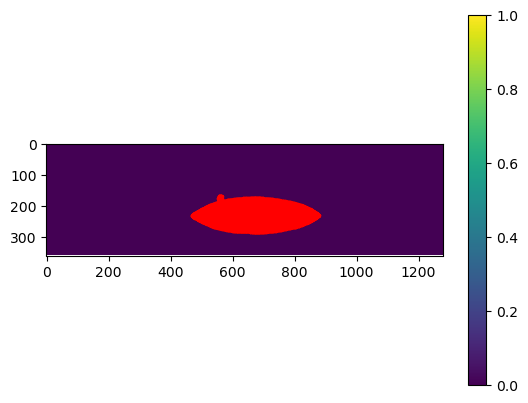

In [8]:
# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

# Plot the 2D array
plt.imshow(data, cmap='viridis')
plt.colorbar()

# Overlay the points
plt.scatter(x, y, color='red', s=2)

# Show the plot
plt.show()

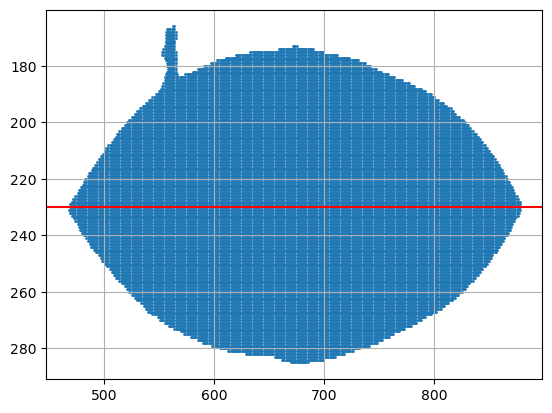

In [9]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()

# Draw the horizontal line at 230
plt.axhline(y=half_line_y, color='r', linestyle='-')


#plt.ylim(400,-200)
plt.show()

# 2) Define Functions

In [23]:
def plot_extreme_x_points(x_edge, y_edge, target_y):
    """
    Plots the smallest and largest x values at target_y along with the other points.
    
    Parameters:
    x_edge (list): List of x coordinates.
    y_edge (list): List of y coordinates.
    target_y (int or float): The y value to filter the x values.
    """
    # Separate points at target_y and other points
    x_at_target_y = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] == target_y]
    x_other = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]
    y_other = [y_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]

    # Find the smallest and largest x values at target_y
    if x_at_target_y:  # Ensure there's at least one point at target_y
        x_min = min(x_at_target_y)
        x_max = max(x_at_target_y)

        # Create new lists for plotting the points at target_y
        x_filtered = [x_min, x_max]
        y_filtered = [target_y, target_y]

    new_x = np.concatenate((x_filtered, x_other))
    new_y = np.concatenate((y_filtered, y_other))

    return new_x, new_y

# 3) Perform Loop

## 3.1) Left Angle

In [60]:
angles_list = []

#for i in tqdm(range(no_frames)):

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 3000 or 230 not in y:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = (-np.min(x_upper) + np.max(x_upper)) / 4 + np.min(x_upper)
        quarter_mask = [x_upper <= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, half_line_y)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_left = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_left<0:
            angle = np.abs(angle_tangent_degrees_left)
        
        if angle_tangent_degrees_left>0:
            angle = 180 - angle_tangent_degrees_left

        angles_list.append(angle)




    

100%|██████████| 543/543 [04:26<00:00,  2.04it/s]


In [61]:
angle_left = np.array(angles_list)
angle_left

array([119.10354565, 153.08565598, 139.84931257, 119.73230887,
        85.41278623, 100.78107354, 142.62054149, 131.52937928,
       137.78910156, 124.02778173, 138.71430491,  38.6456839 ,
       136.87251797, 131.13831576, 106.37811095, 119.24640701,
       109.32936892, 109.18846451,  89.33999334,  88.75190244,
        74.12077547,  90.00739356,  89.79764393,  87.81979099,
        80.72285449,  68.45857718,  57.03178857,  84.24958049,
        79.26019811,  71.34155351,  70.18784719,  48.86676371,
        52.82729938,  75.78733571,  52.63805399,  54.76097775,
        58.0745145 ,  52.70074954,  50.70163057,  35.53062413,
        30.49120725,  35.45265952,  33.54446593,  31.98082525,
        43.1399875 ,  39.1836716 ,  22.96451033,  23.71091643,
       158.51137731,  29.21316253,  25.33807624,  29.01616697,
        24.08680636,  21.68050037,  14.25506207, 168.79246426,
        21.74011215,  29.5695473 ,  23.71999047,  37.74763636,
        64.56530401,  15.36787131,  15.68949167,  18.58

In [63]:
i_left = np.arange(30, 543, 1)

In [65]:
data1 = np.column_stack((i_left, angle_left))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Left_angel_model2.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [66]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Left_angel_model2.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i_left = loaded_data[:, 0]
theta_left = loaded_data[:, 1]

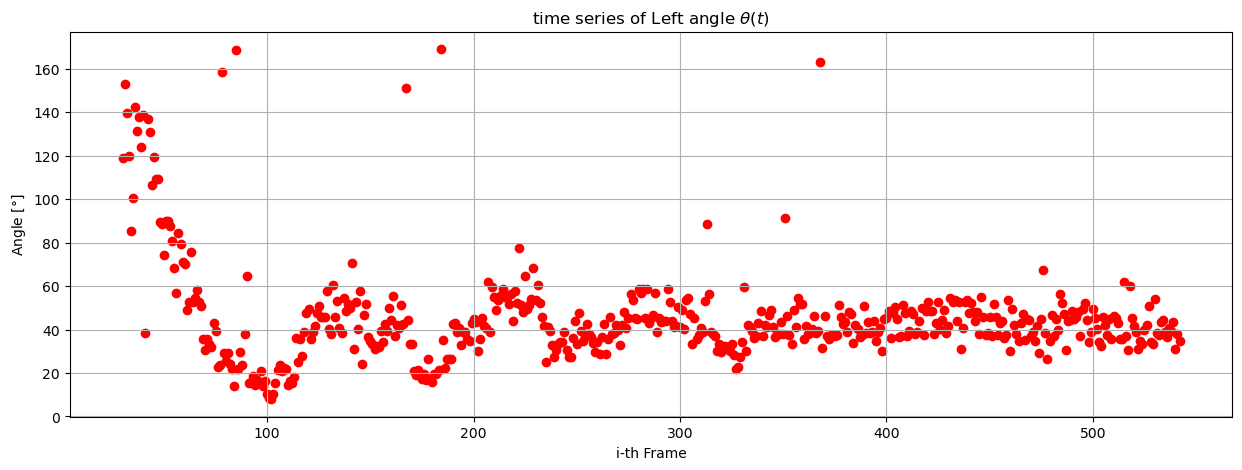

In [141]:
plt.figure(figsize=(15,5))
plt.scatter(i_left, theta_left, color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Left angle $\\theta(t)$")
plt.grid(True)

## 3.2) Right Angle

In [88]:
angles_list = []

#for i in tqdm(range(no_frames)):

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 3000 or 230 not in y:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = -(-np.min(x_upper) + np.max(x_upper)) / 4 + np.max(x_upper)
        quarter_mask = [x_upper >= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, half_line_y)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_right  = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_right < 0:
            angle = 180 + angle_tangent_degrees_right
        
        if angle_tangent_degrees_right > 0:
            angle = angle_tangent_degrees_right

        angles_list.append(angle)




    

100%|██████████| 543/543 [04:14<00:00,  2.14it/s]


In [89]:
angle_right = np.array(angles_list)
angle_right

array([  5.2455877 , 118.4834986 ,  15.44562082,   6.22206906,
       109.77862701,  30.37239846, 136.40302566,  99.99717858,
       117.68305941, 122.03693663, 116.65871745,  88.67834697,
        52.81885627, 108.07629353, 139.18822352, 107.35912198,
       109.57813222,  93.32586908,  89.57306287,  89.99381679,
        89.90433256,  89.70762673,  90.77892142,  90.68425407,
        90.88606759,  88.64828949,  88.2200063 ,  91.77939164,
        79.88110426,  90.63201037,  78.45787939,  90.13465631,
        91.36336673,  77.99727084,  80.87548499,  79.95592781,
        78.90378861,  83.8050147 ,  73.31290801,  78.64338873,
        76.33978645,  51.48670252,  45.29131276,  57.44055876,
        52.68462986,  53.37187346,  47.60550163,  44.15179706,
        55.20178173,  41.52337537,  42.47919832,  42.24287611,
        38.64724205,  32.07175701,  29.76894562,  35.49986379,
        35.71970337,  34.74410049,  35.13248631,  41.25074353,
        44.98811247,  37.9021158 ,  22.77632645,  19.08

In [90]:
i_right = np.arange(30, 543, 1)

In [91]:
data1 = np.column_stack((i_right, angle_right))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Right_angel_model2.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [92]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Right_angel_model2.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i_right = loaded_data[:, 0]
theta_right = loaded_data[:, 1]

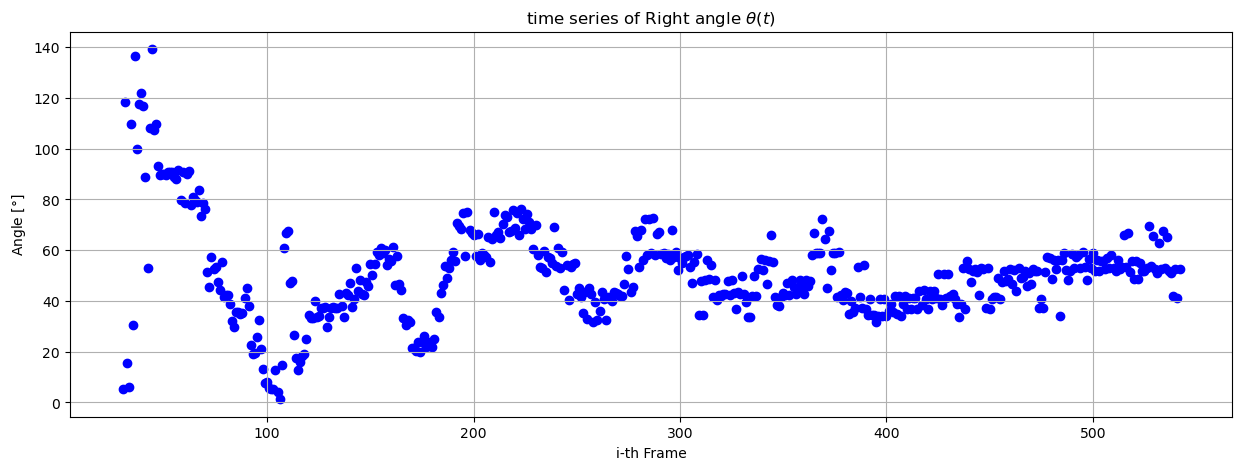

In [142]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, theta_right, color = 'blue')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Right angle $\\theta(t)$")
plt.grid(True)

# 3.3) Compare 

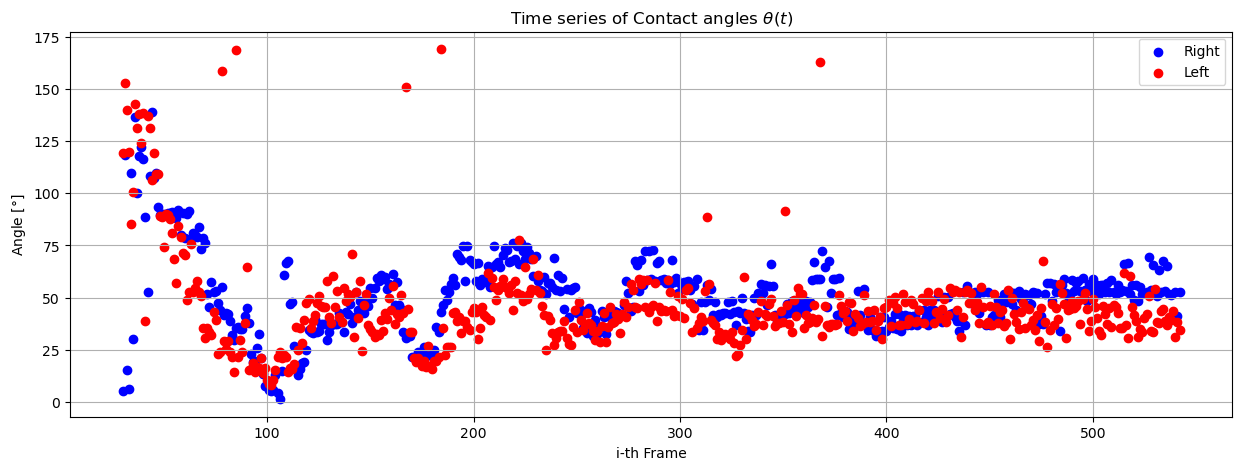

In [144]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, theta_right, label = 'Right', color = 'blue')
plt.scatter(i_left, theta_left, label = 'Left', color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("Time series of Contact angles $\\theta (t)$")
plt.grid(True)
plt.legend()

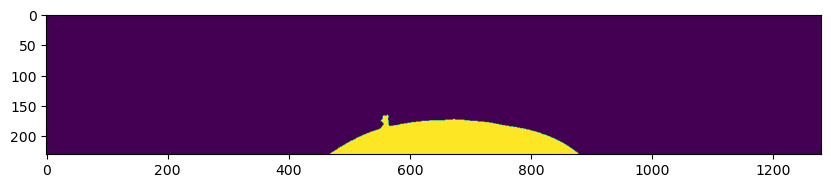

In [140]:
i = 200
plt.figure(figsize=(10,10))
plt.imshow(processed_edges[0, i], cmap='viridis')  

plt.ylim(230, 0)

#plt.colorbar()  
plt.show()